# Data Overview

### Imports

In [1]:
import os
import sys
import gc
from pathlib import Path
from typing import List
from dotenv import load_dotenv

import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from src.logging_setup import setup_logging
    from src.recs.data_preprocessing import load_and_encode_data, preprocess_data
    from src.recs.feature_engineering import engineer_features
    from src.recs.target_engineering import engineer_targets
    from src.recs.train_test_split import temporal_train_test_split
except ImportError:
    PROJECT_ROOT = Path.cwd().parent
    if str(PROJECT_ROOT) not in sys.path:
        sys.path.insert(0, str(PROJECT_ROOT))
    from src.logging_setup import setup_logging
    from src.recs.data_preprocessing import load_and_encode_data, preprocess_data
    from src.recs.feature_engineering import engineer_features
    from src.recs.target_engineering import engineer_targets
    from src.recs.train_test_split import temporal_train_test_split

[2026-01-13 12:15:50,528] [INFO] Logging to /home/mle-user/mle_projects/final_project/logs/logs_data_preprocessing.json setup completed
[2026-01-13 12:15:50,537] [INFO] Logging to /home/mle-user/mle_projects/final_project/logs/logs_feature_engineering.json setup completed
[2026-01-13 12:15:50,546] [INFO] Logging to /home/mle-user/mle_projects/final_project/logs/logs_target_engineering.json setup completed
[2026-01-13 12:15:50,555] [INFO] Logging to /home/mle-user/mle_projects/final_project/logs/logs_train_test_split.json setup completed


### Config

In [2]:
# Set working directory to project root (use cwd().parent for notebooks in notebooks/ folder)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
os.chdir(PROJECT_ROOT)

In [3]:
logger = setup_logging('project_notebook')

[2026-01-13 12:15:50,578] [INFO] Logging to /home/mle-user/mle_projects/final_project/logs/logs_project_notebook.json setup completed


In [4]:
# Load environment variables
load_dotenv()

True

In [5]:
# Constants
# Data directory
DATA_DIR = os.getenv('DATA_DIR', './data')
# Results directory
RESULTS_DIR = os.getenv('RESULTS_DIR', './results')
# Raw data file
RAW_DATA_FILE = os.getenv('RAW_DATA_FILE', 'train_ver2.csv')
# Preprocessed data file
PREPROCESSED_DATA_FILE = os.getenv('PREPROCESSED_DATA_FILE', 'data_preprocessed.parquet')
# Preprocessed data summary file
PREPROCESSED_DATA_SUMMARY_FILE = os.getenv('PREPROCESSED_DATA_SUMMARY_FILE', 'data_preprocessed_summary.parquet')


In [6]:
# Create directories if they don't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

### Helper functions

In [ ]:
# Data summary helper function
def data_summary(
    df: pl.DataFrame, 
    name: str,
    results_dir: str = RESULTS_DIR
):
    '''
        Display a quick overview of a Polars DataFrame.
    '''
    print(f'===== {name.upper()} =====')

    # Sample rows
    print('Sample rows:')
    display(df.head())

    # Shape
    rows, cols = df.shape
    print(f'Shape: {rows} rows x {cols} columns')

    # Data types
    print('Data types:')
    for col, dt in zip(df.columns, df.dtypes):
        print(f'{col}: {dt}')

    # Numeric columns
    print('Summary for numeric columns:')
    numeric_types = (pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                     pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                     pl.Float32, pl.Float64)
    numeric_cols = [c for c, dt in zip(df.columns, df.dtypes)
                    if isinstance(dt, numeric_types)]
    if numeric_cols:
        summary_name = f"{name}_numeric_summary"
        globals()[summary_name] = df.select(numeric_cols).describe()
        display(globals()[summary_name])
        globals()[summary_name].write_parquet(f'{results_dir}/{summary_name}.parquet')
    else:
        print('No numeric columns')

    # Unique values
    print(f'Unique customer id values: {df["ncodpers"].n_unique()}')
    print('Unique values:')
    cat_like_types = (pl.Categorical, pl.Boolean, pl.Date)
    cat_like_cols = [c for c, dt in zip(df.columns, df.dtypes)
                     if isinstance(dt, cat_like_types)]
    for col in cat_like_cols:
        print(f'\nColumn: {col}')
        display(df.select(pl.col(col).value_counts()))

    # Missing values
    print('Missing values:')
    display(df.null_count())

In [8]:
# Plot correlation heatmap helper function (memory-efficient version)
def plot_correlation_heatmap(
    df: pl.DataFrame,
    results_dir: str = RESULTS_DIR,
    sample_size: int = 100_000  # Sample for memory efficiency
):
    '''
        Plot correlation heatmap for numeric and boolean columns in a Polars DataFrame.
        Returns the correlation matrix and displays top 10 strongest correlations.
        Uses sampling for memory efficiency on large datasets.
    '''
    
    # Force garbage collection before starting
    gc.collect()
    
    # Identify numeric and boolean columns
    numeric_types = (pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                     pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                     pl.Float32, pl.Float64)
    numeric_cols = [c for c, dt in zip(df.columns, df.dtypes)
                    if isinstance(dt, numeric_types)]
    boolean_cols = [c for c, dt in zip(df.columns, df.dtypes)
                    if isinstance(dt, pl.Boolean)]
    
    all_cols = numeric_cols + boolean_cols
    print(f'Selected {len(numeric_cols)} numeric and {len(boolean_cols)} boolean columns')
    
    # Sample data if too large (correlations from sample are statistically similar)
    n_rows = df.shape[0]
    if n_rows > sample_size:
        print(f'Sampling {sample_size:,} rows from {n_rows:,} for correlation computation')
        df_sample = df.sample(n=sample_size, seed=42)
    else:
        df_sample = df
    
    # Select and cast only needed columns to Float32 (more memory efficient than Float64)
    df_casted = df_sample.select(
        [pl.col(c).cast(pl.Float32) for c in all_cols]
    )
    del df_sample
    gc.collect()
    
    # Check for nulls before filling
    null_counts = df_casted.null_count()
    cols_with_nulls = [col for col in all_cols if null_counts[col][0] > 0]
    if cols_with_nulls:
        print(f'Found {len(cols_with_nulls)} columns with null values')
        print('Filling nulls with column means for correlation computation')
    
    # Fill nulls with column means to enable correlation computation
    df_filled = df_casted.select(
        [pl.col(c).fill_null(pl.col(c).mean()) for c in all_cols]
    )
    del df_casted
    gc.collect()

    # Compute correlation matrix using Polars (returns a DataFrame)
    corr_df = df_filled.corr()
    del df_filled
    gc.collect()
    
    # Convert to numpy for plotting (Polars corr() returns DataFrame with column names as first col)
    corr_matrix = corr_df.to_numpy().astype(np.float32)
    
    print(f'Correlation matrix shape: {corr_matrix.shape}')
    
    # Determine if we should show annotations (disable for large matrices)
    n_cols = len(all_cols)
    show_annot = n_cols <= 30  # Only annotate if 30 or fewer columns
    figsize = (min(20, n_cols * 0.5 + 5), min(20, n_cols * 0.5 + 5))

    # Create heatmap plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix, 
        annot=show_annot, 
        cmap='coolwarm', 
        linewidths=0.5 if n_cols <= 50 else 0, 
        center=0,
        xticklabels=all_cols,
        yticklabels=all_cols,
        fmt='.2f' if show_annot else None,
        annot_kws={'size': 6} if show_annot else None
    )
    plt.title('Correlation Map of Features')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    
    plt.savefig(f'{results_dir}/correlation_heatmap.png', dpi=100, bbox_inches='tight')
    print(f'Correlation heatmap saved to: {results_dir}/correlation_heatmap.png')
    
    plt.show()
    plt.close()
    gc.collect()

    # Find top 10 strongest correlations (excluding self-correlations)
    correlations = []
    n = len(all_cols)
    for i in range(n):
        for j in range(i + 1, n):  # Upper triangle only
            correlations.append({
                'feature_1': all_cols[i],
                'feature_2': all_cols[j],
                'correlation': float(corr_matrix[i, j])
            })
    
    # Create Polars DataFrame and sort by absolute correlation
    top_corrs = (
        pl.DataFrame(correlations)
        .with_columns(pl.col('correlation').abs().alias('abs_correlation'))
        .sort('abs_correlation', descending=True)
        .head(10)
        .drop('abs_correlation')
    )
    
    print('Top 10 strongest correlations:')
    display(top_corrs)

    return corr_df, top_corrs

### Raw Data Overview

In [9]:
# Load raw data
df = pl.read_csv(
    f"{DATA_DIR}/{RAW_DATA_FILE}", 
    infer_schema_length=10000,
    null_values=['NA', 'N/A', 'NaN', 'nan', 'null', 'None', '', ' '],
    ignore_errors=True # Load data even if some rows are corrupted
)

In [10]:
# Data overview
print('Data overview')
raw_data_summary = df.describe()
display(raw_data_summary)
raw_data_summary.write_parquet(f'{RESULTS_DIR}/raw_data_summary.parquet')

# Shape
rows, cols = df.shape
print(f'Shape: {rows} rows x {cols} columns')

# Data types
print('Data types:')
display(df.dtypes)
  
# Unique values (top 10 per column)
print('Unique values:')
for col in df.columns:
    print(f'Column: {col}')
    display(df[col].value_counts().head(10))

# Missing values
print('Missing values:')
display(df.null_count())

Data overview


statistic,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
str,str,f64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64
"""count""","""13647309""",1.3647309e7,"""13619575""","""13619575""","""13619505""","""13647309""","""13619575""","""13619575""","""13647309""","""13619575""","""24793""",1.3496654e7,"""13497528""","""13619575""","""13619575""","""1808""","""13461183""","""13619575""","""13619574""","""13553718""","""13553718""","""13619575""",1.0852934e7,"""13457941""",1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,"""13631246""","""13631246""",1.3647309e7
"""null_count""","""0""",0.0,"""27734""","""27734""","""27804""","""0""","""27734""","""27734""","""0""","""27734""","""13622516""",150655.0,"""149781""","""27734""","""27734""","""13645501""","""186126""","""27734""","""27735""","""93591""","""93591""","""27734""",2.794375e6,"""189368""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""16063""","""16063""",0.0
"""mean""",null,834904.211501,null,null,null,null,null,null,null,null,null,1.00081,null,null,null,null,null,null,null,null,null,null,134254.318238,null,0.000102,0.000023,0.655484,0.000394,0.080867,0.009474,0.009727,0.129008,0.043306,0.001779,0.001661,0.042967,0.082744,0.018486,0.005887,0.009171,0.002627,0.052536,0.044389,0.025608,0.003848,null,null,0.127916
"""std""",null,431565.025784,null,null,null,null,null,null,null,null,null,0.039877,null,null,null,null,null,null,null,null,null,null,230620.238822,null,0.010113,0.004812,0.47521,0.019844,0.272631,0.096873,0.098143,0.335209,0.203545,0.042138,0.040721,0.202782,0.275494,0.134701,0.076498,0.095325,0.051191,0.223106,0.205957,0.157962,0.061911,null,null,0.333996
"""min""","""2015-01-28""",15889.0,"""A""","""AD""","""H""",""" 2""","""1995-01-16""",""" 0""",""" 0""",""" 1""","""2015-07-01""",1.0,"""A""","""N""","""N""","""N""","""004""","""N""",""" 1""",""" 1""","""ALAVA""",""" 0""",1202.73,"""01 - TOP""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,""" 0""",""" 0""",0.0
"""25%""",null,452813.0,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null,null,null,null,68710.98,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0
"""50%""",null,931893.0,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null,null,null,null,101850.0,null,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0
"""75%""",null,1.199286e6,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null,null,null,null,155955.96,null,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0
"""max""","""2016-05-28""",1.553689e6,"""S""","""ZW""","""V""","""164""","""2016-05-31""",""" 1""","""-999999""","""99""","""2016-05-30""",4.0,"""R""","""S""","""S""","""S""","""RED""","""S""",""" 1""","""52""","""ZARAGOZA""",""" 1""",2.8894e7,"""03 - UNIVERSITARIO""",1.0,1.0,1.0,1.0,1.0,1.0,1.

Shape: 13647309 rows x 48 columns
Data types:


[String,
 Int64,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 Float64,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 Float64,
 String,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 String,
 String,
 Int64]

Unique values:
Column: fecha_dato


fecha_dato,count
str,u32
"""2015-04-28""",630367
"""2015-02-28""",627394
"""2015-06-28""",632110
"""2016-04-28""",928274
"""2015-07-28""",829817
"""2016-05-28""",931453
"""2015-05-28""",631957
"""2015-11-28""",906109
"""2016-02-28""",920904


Column: ncodpers


ncodpers,count
i64,u32
918696,17
371287,11
301726,11
1197976,11
153978,6
333360,17
976637,17
1456992,9
1156129,17


Column: ind_empleado


ind_empleado,count
str,u32
"""S""",17
"""F""",2523
"""A""",2492
null,27734
"""N""",13610977
"""B""",3566


Column: pais_residencia


pais_residencia,count
str,u32
"""ZA""",119
"""HN""",282
"""MX""",2573
"""CD""",17
"""CA""",446
"""SA""",79
"""GT""",130
"""LB""",17
"""VE""",2331


Column: sexo


sexo,count
str,u32
"""H""",6195253
null,27804
"""V""",7424252


Column: age


age,count
str,u32
""" 17""",11953
""" 21""",675988
""" 23""",779884
""" 19""",21597
""" 15""",13118
""" 69""",77745
"""116""",63
""" 28""",240192
"""115""",82


Column: fecha_alta


fecha_alta,count
str,u32
"""2007-11-03""",439
"""1995-09-11""",464
"""2006-03-10""",1239
"""2005-06-07""",1371
"""2003-04-07""",2458
"""2011-11-17""",10529
"""2010-04-17""",563
"""2005-12-29""",2241
"""2000-05-10""",1270


Column: ind_nuevo


ind_nuevo,count
str,u32
""" 0""",12808368
null,27734
""" 1""",811207


Column: antiguedad


antiguedad,count
str,u32
""" 91""",39083
""" 113""",43487
""" 237""",13165
""" 41""",99968
""" 118""",46059
""" 81""",48081
""" 84""",38932
""" 242""",7425
""" 40""",103485


Column: indrel


indrel,count
str,u32
"""99""",24793
null,27734
""" 1""",13594782


Column: ult_fec_cli_1t


ult_fec_cli_1t,count
str,u32
"""2016-04-13""",82
"""2016-04-18""",78
"""2015-11-04""",100
"""2015-11-27""",91
"""2015-09-22""",108
"""2015-09-25""",73
"""2015-11-24""",109
"""2016-02-18""",64
"""2016-03-18""",77


Column: indrel_1mes


indrel_1mes,count
f64,u32
4.0,306
3.0,4350
2.0,1317
null,150655
1.0,13490681


Column: tiprel_1mes


tiprel_1mes,count
str,u32
"""N""",4
"""R""",870
"""A""",6187123
"""I""",7304875
null,149781
"""P""",4656


Column: indresi


indresi,count
str,u32
"""S""",13553711
null,27734
"""N""",65864


Column: indext


indext,count
str,u32
"""N""",12974839
null,27734
"""S""",644736


Column: conyuemp


conyuemp,count
str,u32
"""N""",1791
null,13645501
"""S""",17


Column: canal_entrada


canal_entrada,count
str,u32
"""KED""",3011
"""KBB""",1298
"""KCO""",179
"""KFT""",8036
"""KEB""",370
"""KFN""",4520
"""KFI""",881
"""KCR""",196
"""KCB""",5187


Column: indfall


indfall,count
str,u32
"""N""",13584813
null,27734
"""S""",34762


Column: tipodom


tipodom,count
str,u32
""" 1""",13619574
null,27735


Column: cod_prov


cod_prov,count
str,u32
"""10""",129912
""" 5""",38783
"""31""",88618
"""50""",342543
"""44""",22525
"""16""",57310
"""49""",50927
"""15""",429322
"""12""",104295


Column: nomprov


nomprov,count
str,u32
"""SEVILLA""",605164
"""SORIA""",17660
"""LUGO""",84962
"""JAEN""",64363
"""ASTURIAS""",265749
"""CORDOBA""",144679
null,93591
"""GIPUZKOA""",71567
"""CUENCA""",57310


Column: ind_actividad_cliente


ind_actividad_cliente,count
str,u32
""" 0""",7384390
null,27734
""" 1""",6235185


Column: renta


renta,count
f64,u32
104308.56,34
201153.09,11
38750.28,34
60790.05,33
40469.31,11
80767.65,17
118684.02,17
91833.3,17
268543.56,9


Column: segmento


segmento,count
str,u32
"""02 - PARTICULARES""",7960220
"""03 - UNIVERSITARIO""",4935579
"""01 - TOP""",562142
null,189368


Column: ind_ahor_fin_ult1


ind_ahor_fin_ult1,count
i64,u32
1,1396
0,13645913


Column: ind_aval_fin_ult1


ind_aval_fin_ult1,count
i64,u32
1,316
0,13646993


Column: ind_cco_fin_ult1


ind_cco_fin_ult1,count
i64,u32
0,4701721
1,8945588


Column: ind_cder_fin_ult1


ind_cder_fin_ult1,count
i64,u32
0,13641933
1,5376


Column: ind_cno_fin_ult1


ind_cno_fin_ult1,count
i64,u32
0,12543689
1,1103620


Column: ind_ctju_fin_ult1


ind_ctju_fin_ult1,count
i64,u32
0,13518012
1,129297


Column: ind_ctma_fin_ult1


ind_ctma_fin_ult1,count
i64,u32
1,132742
0,13514567


Column: ind_ctop_fin_ult1


ind_ctop_fin_ult1,count
i64,u32
1,1760616
0,11886693


Column: ind_ctpp_fin_ult1


ind_ctpp_fin_ult1,count
i64,u32
1,591008
0,13056301


Column: ind_deco_fin_ult1


ind_deco_fin_ult1,count
i64,u32
1,24275
0,13623034


Column: ind_deme_fin_ult1


ind_deme_fin_ult1,count
i64,u32
1,22668
0,13624641


Column: ind_dela_fin_ult1


ind_dela_fin_ult1,count
i64,u32
0,13060928
1,586381


Column: ind_ecue_fin_ult1


ind_ecue_fin_ult1,count
i64,u32
1,1129227
0,12518082


Column: ind_fond_fin_ult1


ind_fond_fin_ult1,count
i64,u32
0,13395025
1,252284


Column: ind_hip_fin_ult1


ind_hip_fin_ult1,count
i64,u32
1,80336
0,13566973


Column: ind_plan_fin_ult1


ind_plan_fin_ult1,count
i64,u32
1,125159
0,13522150


Column: ind_pres_fin_ult1


ind_pres_fin_ult1,count
i64,u32
1,35857
0,13611452


Column: ind_reca_fin_ult1


ind_reca_fin_ult1,count
i64,u32
0,12930329
1,716980


Column: ind_tjcr_fin_ult1


ind_tjcr_fin_ult1,count
i64,u32
0,13041523
1,605786


Column: ind_valo_fin_ult1


ind_valo_fin_ult1,count
i64,u32
1,349475
0,13297834


Column: ind_viv_fin_ult1


ind_viv_fin_ult1,count
i64,u32
1,52511
0,13594798


Column: ind_nomina_ult1


ind_nomina_ult1,count
str,u32
""" 1""",745961
""" 0""",12885285
null,16063


Column: ind_nom_pens_ult1


ind_nom_pens_ult1,count
str,u32
""" 1""",810085
null,16063
""" 0""",12821161


Column: ind_recibo_ult1


ind_recibo_ult1,count
i64,u32
1,1745712
0,11901597


Missing values:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,27734,27734,27804,0,27734,27734,0,27734,13622516,150655,149781,27734,27734,13645501,186126,27734,27735,93591,93591,27734,2794375,189368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16063,16063,0


In [11]:
# Clean up
del df
gc.collect()

0

#### Raw Dataset EDA Summary

Raw Dataset Overview:
Raw dataset contains of 13.6 million customer snapshots spanning 17 months (from January'2015 till May'2016) across 1.55 million unique customers. 

Features are:

Core Identifiers
- fecha_dato - month identifier (2015-01-28 to 2016-05-28);
- ncodpers - customer id (1.55M unique customers);

Demographics & Status
- ind_empleado - employment status (A=employee, B=ex-employee, F=on leave, N=non-employee, S=unknown);
- pais_residencia - country of residence;
- sexo - gender (H=male, V=female);
- age - customer age (0-169);
- fecha_alta - first contract date with bank;
- ind_nuevo - indicator of wheither a customer is new during last 6 months (1=new customer, 0=existing);
- antiguedad - tenure in months;

Customer Relationship
- indrel - primary customer (1=primary, 99=primary this month only);
- ult_fec_cli_1t - last premium customer date;
- indrel_1mes - customer type start of month (1=premium, 2=owner, P=potential);
- tiprel_1mes - customer relation (A=active, I=inactive, P=former, R=potential);
- indresi - foreigner indicator (1=non-resident);
- indext - foreigner index;
- conyuemp - spouse of employee (S=yes, N=no);

Address & Activity
- canal_entrada - acquisition channel;
- indfall - deceased indicator (N=no, S=yes);
- tipodom - address type (1=primary);
- cod_prov - province code;
- nomprov - province name;
- ind_actividad_cliente - indicator of active customer (1=yes, 0=no);

Financial
- renta - household income (in euro);
- segmento - customer segment (01-vip, 02-middle, 03-university);

Bank products (24 binary features, 1-customer has product, 0-otherwise)
- ind_ahor_fin_ult1 - savings account;
- ind_aval_fin_ult1 - guarantees;
- ind_cco_fin_ult1  - checking account;
- ind_cder_fin_ult1 - derivatives;
- ind_cno_fin_ult1  - payroll;
- ind_ctju_fin_ult1 - junior account;
- ind_ctma_fin_ult1 - particular account 3;
- ind_ctop_fin_ult1 - particular account;
- ind_ctpp_fin_ult1 - particular account 2;
- ind_deco_fin_ult1 - short-term deposit;
- ind_deme_fin_ult1 - medium-term deposit;
- ind_dela_fin_ult1 - long-term deposit;
- ind_ecue_fin_ult1 - digital account;
- ind_fond_fin_ult1 - funds;
- ind_hip_fin_ult1  - mortgage;
- ind_plan_fin_ult1 - pension plan;
- ind_pres_fin_ult1 - loan;
- ind_reca_fin_ult1 - tax account;
- ind_tjcr_fin_ult1 - credit card;
- ind_valo_fin_ult1 - securities;
- ind_viv_fin_ult1  - home account;
- ind_nomina_ult1   - payroll account;
- ind_nom_pens_ult1 - pensions;
- ind_recibo_ult1   - direct debit.

Main issues:

Datatypes
- Features age, antiguedad, ind_nuevo, indrel and similar numeric features are stored as strings with embedded spaces instead of integer or float;
- Binary indicators like indresi, indext, indfall, and ind_actividad_cliente are string-coded (' 0', ' 1', 'S', 'N') instead of proper binary/int (0/1);
- Date features (fecha_dato, fecha_alta, ult_fec_cli_1t) are string type but should be datetime;
- Product ownership columns (ind_ahor_fin_ult1, ind_cco_fin_ult1, etc.) are float/int, but conceptually categorical/binary; so require casting to int8 for consistency;
- Feature renta should be numeric (float), but formatting irregularities (commas, missing decimals) might create parsing issues.

Missing values
- Features ind_empleado, pais_residencia, sexo, ind_nomina_ult1, ind_nom_pens_ult1 each has approximately 0.2% nulls;
- Features indrel, indrel_1mes, tiprel_1mes, segmento have up to 1.1-1.4 missing or null entries;
- Feature renta has approximately 20% missing;
- Several categorical features (conyuemp, tipodom) almost entirely null and possibly irrelevant.

Outliers
- Feature age includes unrealistic values (e.g., 2, 111, 126);
- Feature antiguedad includes extreme or invalid values (e.g., -999999);
- Feature renta contains extreme high values (up to 28M) suggesting inclusion of outliers or data entry errors.

Other issues
- Widespread extra spaces in categorical fields (e.g., " 0", " 1", "  2") that may causing duplicated categories after encoding;
- Inconsistent null encoding (mixed true nulls and placeholder codes like '99' or ' 0');
- Mixed-format categorical labels (features tiprel_1mes and indrel_1mes exhibit mixed numeric and string categories);
- Feature renta distribution heavily right-skewed (median €101K, max €28M);
- High class imbalance across product ownership columns — many features dominated by zeros (e.g., ind_aval_fin_ult1, ind_fond_fin_ult1), which impacts modeling.

Things to be done:

- String cleaning (strip spaces, standardize nulls);
- Type casting (dates to datetime, numerics to int/float);
- Outlier clipping (age: 18-90, renta: IQR bounds);
- Dealing with missing values (imputation strategy for renta: median by customer segment and province, falling back to global median; demographics: mode, categoricals: inpute with 'missing'; targets: drop missing);
- Log transformation of renta;
- Create 'customer_period' feature as the difference between 'fecha_data' and 'fecha_alta' in months;
- Feature dropping (features with high proportion of missing values 'ult_fec_cli_1t', 'conyuemp'; non-indicative features 'tipodom', 'indext', 'nomprov'; 'fecha_alta' feature as CatBoost cannot handle dates; 'antiguedad' feature as it is highly correlated with 'customer_period' feature).

### Data Preprocessing

In [12]:
# Load raw data and properly encode categorical columns
df_encoded = load_and_encode_data(DATA_DIR, RESULTS_DIR, RAW_DATA_FILE, 'encoding_maps.json')
# Preprocess data
df_preprocessed = preprocess_data(df_encoded, DATA_DIR, RESULTS_DIR, PREPROCESSED_DATA_FILE, 'preprocessed_data_summary.parquet')

[2026-01-13 12:16:23,122] [INFO] Loading raw data from: ./data/train_ver2.csv
[2026-01-13 12:16:41,407] [INFO] Loaded 13647309 rows x 48 columns
[2026-01-13 12:16:41,408] [INFO] Applying data type transformations
[2026-01-13 12:16:41,794] [INFO] Parsed date columns
[2026-01-13 12:16:46,756] [INFO] Encoded categorical columns to Categorical
[2026-01-13 12:16:58,112] [INFO] Encoded boolean and product columns to Boolean
[2026-01-13 12:17:00,448] [INFO] Casted numeric columns to UInt8, UInt32 and Float32
[2026-01-13 12:17:00,449] [INFO] Final schema:
[2026-01-13 12:17:00,450] [INFO]   fecha_dato: Date
[2026-01-13 12:17:00,451] [INFO]   ncodpers: String
[2026-01-13 12:17:00,452] [INFO]   ind_empleado: Categorical
[2026-01-13 12:17:00,452] [INFO]   pais_residencia: Categorical
[2026-01-13 12:17:00,453] [INFO]   sexo: Categorical
[2026-01-13 12:17:00,454] [INFO]   age: UInt8
[2026-01-13 12:17:00,455] [INFO]   fecha_alta: Date
[2026-01-13 12:17:00,455] [INFO]   ind_nuevo: Boolean
[2026-01-13 

In [13]:
# Preprocessed data overview
data_summary(
    df_preprocessed, 
    'preprocessed data',
    RESULTS_DIR
)


===== PREPROCESSED DATA =====

Sample rows:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,indrel,indrel_1mes,tiprel_1mes,indresi,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,customer_period
date,str,cat,cat,cat,u8,bool,cat,cat,cat,bool,cat,bool,cat,bool,f32,cat,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,i32
2015-01-28,"""1375586""","""4""","""ES""","""0""",35,false,"""1""","""1""","""1""",true,"""KHL""",false,"""29""",true,87218.101562,"""2""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0
2015-01-28,"""1050611""","""4""","""ES""","""1""",23,false,"""1""","""1""","""2""",true,"""KHE""",false,"""13""",false,35548.738281,"""3""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,29
2015-01-28,"""1050612""","""4""","""ES""","""1""",23,false,"""1""","""1""","""2""",true,"""KHE""",false,"""13""",false,122179.109375,"""3""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,29
2015-01-28,"""1050613""","""4""","""ES""","""0""",22,false,"""1""","""1""","""2""",true,"""KHD""",false,"""50""",false,119775.539062,"""3""",false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,29
2015-01-28,"""1050614""","""4""","""ES""","""1""",23,false,"""1""","""1""","""1""",true,"""KHE""",false,"""50""",true,99729.117188,"""3""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,29



Shape: 13631246 rows x 42 columns

Data types:
fecha_dato: Date
ncodpers: String
ind_empleado: Categorical
pais_residencia: Categorical
sexo: Categorical
age: UInt8
ind_nuevo: Boolean
indrel: Categorical
indrel_1mes: Categorical
tiprel_1mes: Categorical
indresi: Boolean
canal_entrada: Categorical
indfall: Boolean
cod_prov: Categorical
ind_actividad_cliente: Boolean
renta: Float32
segmento: Categorical
ind_ahor_fin_ult1: Boolean
ind_aval_fin_ult1: Boolean
ind_cco_fin_ult1: Boolean
ind_cder_fin_ult1: Boolean
ind_cno_fin_ult1: Boolean
ind_ctju_fin_ult1: Boolean
ind_ctma_fin_ult1: Boolean
ind_ctop_fin_ult1: Boolean
ind_ctpp_fin_ult1: Boolean
ind_deco_fin_ult1: Boolean
ind_deme_fin_ult1: Boolean
ind_dela_fin_ult1: Boolean
ind_ecue_fin_ult1: Boolean
ind_fond_fin_ult1: Boolean
ind_hip_fin_ult1: Boolean
ind_plan_fin_ult1: Boolean
ind_pres_fin_ult1: Boolean
ind_reca_fin_ult1: Boolean
ind_tjcr_fin_ult1: Boolean
ind_valo_fin_ult1: Boolean
ind_viv_fin_ult1: Boolean
ind_nomina_ult1: Boolean
ind_no

statistic,age,renta,customer_period
str,f64,f64,f64
"""count""",1.3619358e7,1.3631246e7,1.3619358e7
"""null_count""",11888.0,0.0,11888.0
"""mean""",40.193419,127485.703125,79.915143
"""std""",16.983644,206736.96875,66.888488
"""min""",18.0,1202.72998,0.0
"""25%""",24.0,70887.6875,22.0
"""50%""",39.0,98819.3125,51.0
"""75%""",50.0,140936.25,137.0
"""max""",90.0,2.8894396e7,256.0



Unique customer id values: 953543
Unique values:

Column: fecha_dato


fecha_dato
struct[2]
"{2015-11-28,906109}"
"{2015-03-28,626469}"
"{2015-05-28,629152}"
"{2015-04-28,627634}"
"{2015-09-28,865440}"
…
"{2015-12-28,912021}"
"{2015-07-28,829817}"
"{2016-01-28,916269}"



Column: ind_empleado


ind_empleado
struct[2]
"{""4"",13610760}"
"{""2"",3566}"
"{""missing"",11888}"
"{""5"",17}"
"{""3"",2523}"
"{""1"",2492}"



Column: pais_residencia


pais_residencia
struct[2]
"{""CF"",17}"
"{""AR"",4835}"
"{""PR"",101}"
"{""AO"",68}"
"{""BM"",6}"
…
"{""ML"",17}"
"{""CM"",85}"
"{""ZA"",119}"



Column: sexo


sexo
struct[2]
"{""0"",6195177}"
"{""missing"",11958}"
"{""1"",7424111}"



Column: ind_nuevo


ind_nuevo
struct[2]
"{true,811099}"
"{null,11888}"
"{false,12808259}"



Column: indrel


indrel
struct[2]
"{""missing"",11888}"
"{""1"",13594566}"
"{""0"",24792}"



Column: indrel_1mes


indrel_1mes
struct[2]
"{""missing"",133935}"
"{""3"",4322}"
"{""5"",874}"
"{""1"",13490493}"
"{""2"",1316}"
"{""4"",306}"



Column: tiprel_1mes


tiprel_1mes
struct[2]
"{""1"",6186964}"
"{""4"",870}"
"{""2"",7304845}"
"{""3"",4628}"
"{""missing"",133935}"
"{""5"",4}"



Column: indresi


indresi
struct[2]
"{true,13553494}"
"{false,65864}"
"{null,11888}"



Column: canal_entrada


canal_entrada
struct[2]
"{""KFG"",6800}"
"{""KFA"",409660}"
"{""KEY"",35146}"
"{""KEQ"",146}"
"{""KAI"",37699}"
…
"{""KDY"",1960}"
"{""KDF"",726}"
"{""KBY"",642}"



Column: indfall


indfall
struct[2]
"{null,11888}"
"{false,13584599}"
"{true,34759}"



Column: cod_prov


cod_prov
struct[2]
"{""16"",57310}"
"{""49"",50927}"
"{""5"",38783}"
"{""24"",83000}"
"{""4"",60291}"
…
"{""3"",313395}"
"{""38"",70968}"
"{""37"",164237}"



Column: ind_actividad_cliente


ind_actividad_cliente
struct[2]
"{true,6235030}"
"{false,7384328}"
"{null,11888}"



Column: segmento


segmento
struct[2]
"{""3"",4935563}"
"{""1"",562137}"
"{""missing"",173442}"
"{""2"",7960104}"



Column: ind_ahor_fin_ult1


ind_ahor_fin_ult1
struct[2]
"{true,1396}"
"{false,13629850}"



Column: ind_aval_fin_ult1


ind_aval_fin_ult1
struct[2]
"{true,316}"
"{false,13630930}"



Column: ind_cco_fin_ult1


ind_cco_fin_ult1
struct[2]
"{false,4685714}"
"{true,8945532}"



Column: ind_cder_fin_ult1


ind_cder_fin_ult1
struct[2]
"{true,5376}"
"{false,13625870}"



Column: ind_cno_fin_ult1


ind_cno_fin_ult1
struct[2]
"{false,12527779}"
"{true,1103467}"



Column: ind_ctju_fin_ult1


ind_ctju_fin_ult1
struct[2]
"{false,13501950}"
"{true,129296}"



Column: ind_ctma_fin_ult1


ind_ctma_fin_ult1
struct[2]
"{false,13498504}"
"{true,132742}"



Column: ind_ctop_fin_ult1


ind_ctop_fin_ult1
struct[2]
"{false,11870630}"
"{true,1760616}"



Column: ind_ctpp_fin_ult1


ind_ctpp_fin_ult1
struct[2]
"{true,591008}"
"{false,13040238}"



Column: ind_deco_fin_ult1


ind_deco_fin_ult1
struct[2]
"{false,13606971}"
"{true,24275}"



Column: ind_deme_fin_ult1


ind_deme_fin_ult1
struct[2]
"{true,22668}"
"{false,13608578}"



Column: ind_dela_fin_ult1


ind_dela_fin_ult1
struct[2]
"{false,13044877}"
"{true,586369}"



Column: ind_ecue_fin_ult1


ind_ecue_fin_ult1
struct[2]
"{true,1129226}"
"{false,12502020}"



Column: ind_fond_fin_ult1


ind_fond_fin_ult1
struct[2]
"{true,252218}"
"{false,13379028}"



Column: ind_hip_fin_ult1


ind_hip_fin_ult1
struct[2]
"{true,80103}"
"{false,13551143}"



Column: ind_plan_fin_ult1


ind_plan_fin_ult1
struct[2]
"{true,125111}"
"{false,13506135}"



Column: ind_pres_fin_ult1


ind_pres_fin_ult1
struct[2]
"{true,34546}"
"{false,13596700}"



Column: ind_reca_fin_ult1


ind_reca_fin_ult1
struct[2]
"{false,12924012}"
"{true,707234}"



Column: ind_tjcr_fin_ult1


ind_tjcr_fin_ult1
struct[2]
"{true,605725}"
"{false,13025521}"



Column: ind_valo_fin_ult1


ind_valo_fin_ult1
struct[2]
"{true,349475}"
"{false,13281771}"



Column: ind_viv_fin_ult1


ind_viv_fin_ult1
struct[2]
"{true,52511}"
"{false,13578735}"



Column: ind_nomina_ult1


ind_nomina_ult1
struct[2]
"{true,745961}"
"{false,12885285}"



Column: ind_nom_pens_ult1


ind_nom_pens_ult1
struct[2]
"{true,810085}"
"{false,12821161}"



Column: ind_recibo_ult1


ind_recibo_ult1
struct[2]
"{false,11885649}"
"{true,1745597}"



Missing values:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,indrel,indrel_1mes,tiprel_1mes,indresi,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,customer_period
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,11888,11888,0,0,0,11888,0,11888,0,11888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11888


In [14]:
# Average ownership rate for each product

# Get list of product columns first
product_cols = [col for col in df_preprocessed.columns if col.startswith("ind_") and col.endswith("_ult1")]

# Calculate average number of products per customer for EACH product column
avg_by_product = {}

for product in product_cols:
    avg_number_product = (
        df_preprocessed
        .select(pl.col(product).mean().alias(f"avg_{product}"))
        .item(0, 0)  # Extract scalar value
    )
    avg_by_product[product] = avg_number_product
    print(f"Percentage of customers that ever have {product}: {avg_number_product:.2%}")

Percentage of customers that ever have ind_ahor_fin_ult1: 0.01%
Percentage of customers that ever have ind_aval_fin_ult1: 0.00%
Percentage of customers that ever have ind_cco_fin_ult1: 65.63%
Percentage of customers that ever have ind_cder_fin_ult1: 0.04%
Percentage of customers that ever have ind_cno_fin_ult1: 8.10%
Percentage of customers that ever have ind_ctju_fin_ult1: 0.95%
Percentage of customers that ever have ind_ctma_fin_ult1: 0.97%
Percentage of customers that ever have ind_ctop_fin_ult1: 12.92%
Percentage of customers that ever have ind_ctpp_fin_ult1: 4.34%
Percentage of customers that ever have ind_deco_fin_ult1: 0.18%
Percentage of customers that ever have ind_deme_fin_ult1: 0.17%
Percentage of customers that ever have ind_dela_fin_ult1: 4.30%
Percentage of customers that ever have ind_ecue_fin_ult1: 8.28%
Percentage of customers that ever have ind_fond_fin_ult1: 1.85%
Percentage of customers that ever have ind_hip_fin_ult1: 0.59%
Percentage of customers that ever have in

In [15]:
# Average number of products a customer has
product_cols = [col for col in df_preprocessed.columns if col.startswith("ind_") and col.endswith("_ult1")]

# Sum all products per customer, then take the mean
avg_products_per_customer = (
    df_preprocessed
    .select(pl.sum_horizontal(product_cols).alias('total_products'))
    .select(pl.col('total_products').mean())
    .item(0, 0)
)

print(f"Average number of products per customer: {avg_products_per_customer:.4f}")

Average number of products per customer: 1.4629


Selected 3 numeric and 28 boolean columns
Sampling 100,000 rows from 13,631,246 for correlation computation
Found 6 columns with null values
Filling nulls with column means for correlation computation
Correlation matrix shape: (31, 31)
Correlation heatmap saved to: ./results/correlation_heatmap.png


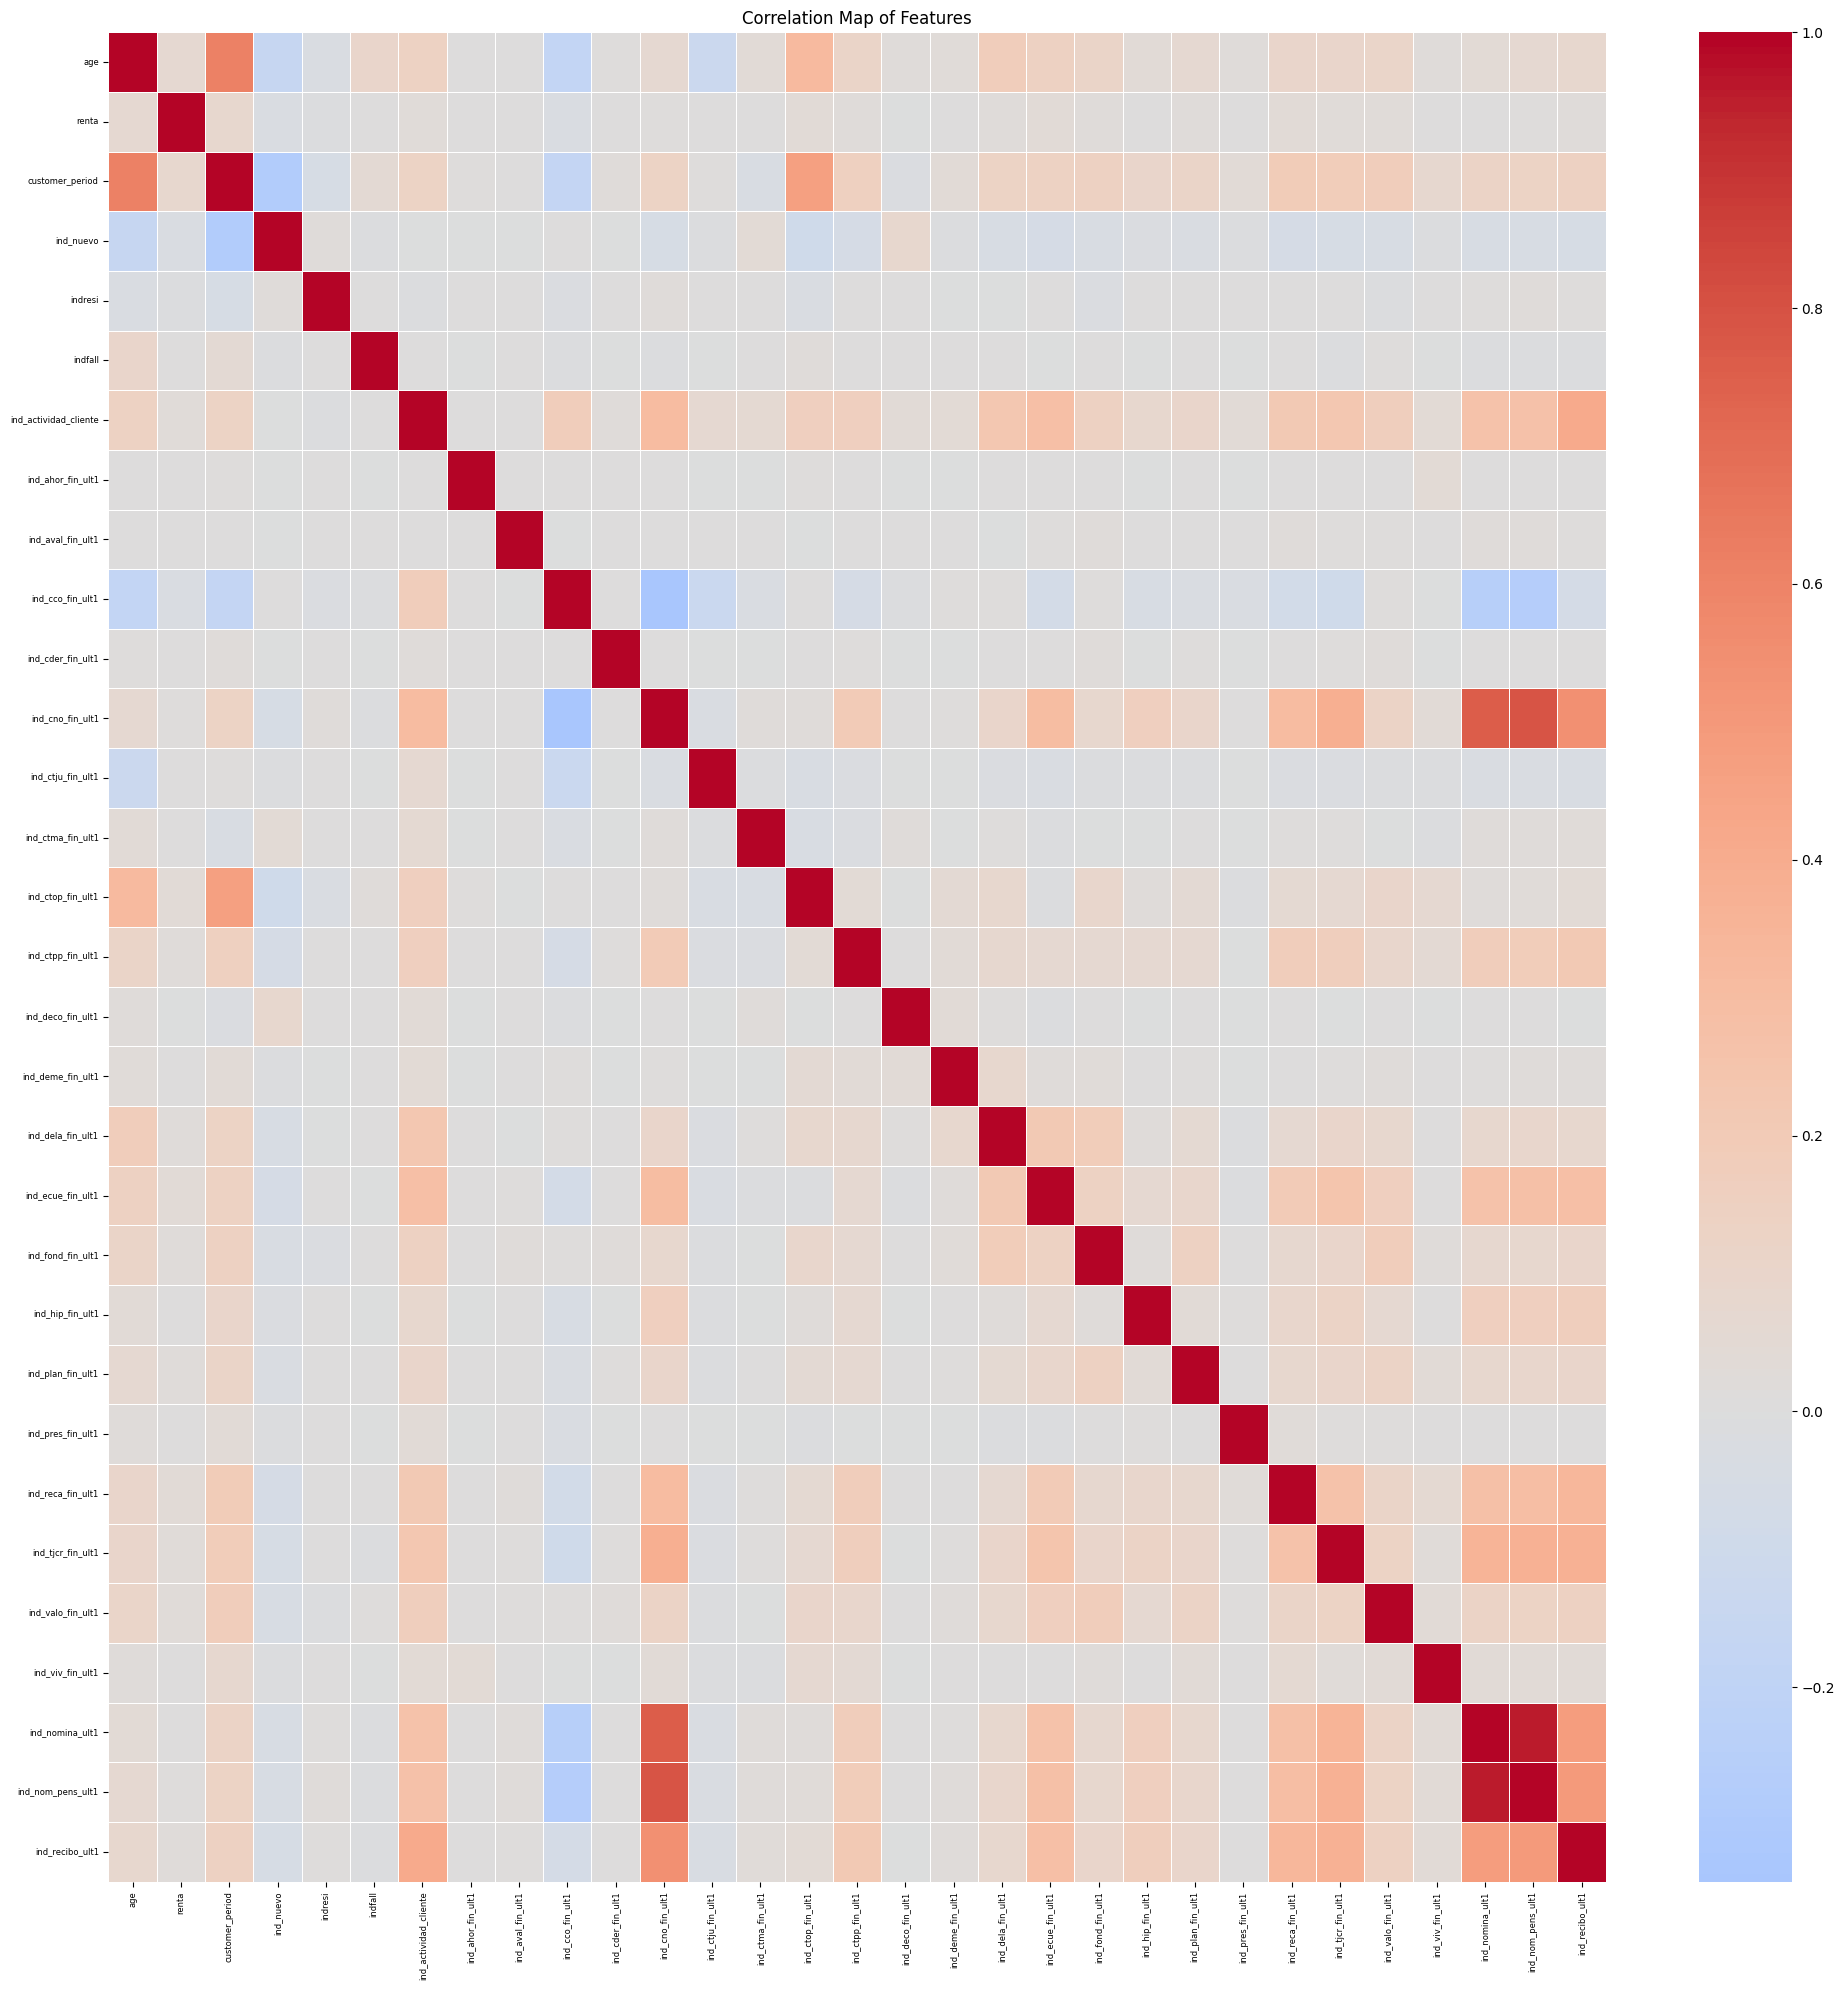

Top 10 strongest correlations:


feature_1,feature_2,correlation
str,str,f64
"""ind_nomina_ult1""","""ind_nom_pens_ult1""",0.957979
"""ind_cno_fin_ult1""","""ind_nom_pens_ult1""",0.789151
"""ind_cno_fin_ult1""","""ind_nomina_ult1""",0.757626
"""age""","""customer_period""",0.608997
"""ind_cno_fin_ult1""","""ind_recibo_ult1""",0.539599
"""ind_nom_pens_ult1""","""ind_recibo_ult1""",0.496207
"""ind_nomina_ult1""","""ind_recibo_ult1""",0.47666
"""customer_period""","""ind_ctop_fin_ult1""",0.460533
"""ind_actividad_cliente""","""ind_recibo_ult1""",0.410194


(shape: (31, 31)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ age       ┆ renta     ┆ customer_ ┆ ind_nuevo ┆ … ┆ ind_viv_f ┆ ind_nomin ┆ ind_nom_p ┆ ind_reci │
 │ ---       ┆ ---       ┆ period    ┆ ---       ┆   ┆ in_ult1   ┆ a_ult1    ┆ ens_ult1  ┆ bo_ult1  │
 │ f64       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │           ┆           ┆ f64       ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 1.0       ┆ 0.067552  ┆ 0.608997  ┆ -0.15592  ┆ … ┆ 0.017089  ┆ 0.043981  ┆ 0.070982  ┆ 0.087537 │
 │ 0.067552  ┆ 1.0       ┆ 0.084607  ┆ -0.028321 ┆ … ┆ 0.008173  ┆ 0.009839  ┆ 0.012131  ┆ 0.022949 │
 │ 0.608997  ┆ 0.084607  ┆ 1.0       ┆ -0.279255 ┆ … ┆ 0.077809  ┆ 0.120552  ┆ 0.131195  ┆ 0.141516 │
 │ -0.15592  ┆ -0.028321 ┆ -0.279255 ┆ 1.0       ┆ … ┆ -0.016082 

In [16]:
# Clean up memory before correlation computation
gc.collect()

# Plot correlation heatmap (using 100k sample for memory efficiency)
plot_correlation_heatmap(
    df_preprocessed, 
    RESULTS_DIR
)

In [17]:
# Free up memory
del df_preprocessed
gc.collect()

0

#### Preprocessed Dataset EDA Summary

Main findings:
- Dataset reveals extreme multilabel imbalance;
Products hightly differ by average ownership rate: 65.63% of bank clients ever have  ind_cco_fin_ult1, although average ownership rates of 10 products are less than 1% (product ind_aval_fin_ult1 is ultra-rare);
- Dataset isn't ultra-sparse;
On average a bank client has 1.46 products;
- Raw data issues were fixed during data preprocessing step;
- Remaining missing values of indrel_1mes, tiprel_1mes, canal_entrada, cod_prov, segmento features are not critical for following CatBoost modeling as CatBoost treats nulls as special category/value, avoiding possible imputting bias.
- Few truly new customers (ind_nuevo mostly 0);
- Strong product correlations - strong co-purchase patterns exist within payroll account, payroll, pension account, direct debit (these fatures even highly correlated cannot be dropped as would be used for target creation, although that behaviour would be captured by engineering of interaction features);
- Moderate correlation between age and customer_period (older clients have longer tenure), that is logical, no need to drop as correlations are not critical for following CatBoost modelling.

Things to be done:
- Engineer features (correlation-based features, log features);
- Create targets;
- Use per-product optimization in order to deal with extreme class imbalance and get recomendations of several products.

ML task:

The core task is multi-label classification to predict which of 24 bank products each customer will newly acquire next month. So the dataframe should be enriched by 24 binary targets (one for each product) that are 1 if the product hadn't been acquired by a customer in the previous month, but has been in the current month, 0 otherwise.

### Features & Targets Engineering

In [18]:
df_preprocessed = engineer_features(DATA_DIR, RESULTS_DIR, PREPROCESSED_DATA_FILE, PREPROCESSED_DATA_SUMMARY_FILE)
df_preprocessed = engineer_targets(DATA_DIR, RESULTS_DIR, PREPROCESSED_DATA_FILE, PREPROCESSED_DATA_SUMMARY_FILE)

[2026-01-13 12:17:19,190] [INFO] Loaded preprocessed data from: ./data/data_preprocessed.parquet
[2026-01-13 12:17:21,987] [INFO] Adding 3m lags...
[2026-01-13 12:17:31,627] [INFO] Added 3m lags for 10 products
[2026-01-13 12:17:31,628] [INFO] Adding 6m lags...
[2026-01-13 12:17:41,508] [INFO] Added 6m lags for 10 products
[2026-01-13 12:17:51,909] [INFO] Added recently acquired features for 10 products
[2026-01-13 12:17:51,966] [INFO] Added interaction feature for ind_nomina_ult1 and ind_nom_pens_ult1
[2026-01-13 12:17:52,030] [INFO] Added interaction feature for ind_cno_fin_ult1 and ind_nom_pens_ult1
[2026-01-13 12:17:52,087] [INFO] Added interaction feature for ind_cno_fin_ult1 and ind_nomina_ult1
[2026-01-13 12:17:52,145] [INFO] Added interaction feature for ind_cno_fin_ult1 and ind_recibo_ult1
[2026-01-13 12:17:52,207] [INFO] Added interaction feature for ind_nomina_ult1 and ind_recibo_ult1
[2026-01-13 12:17:56,299] [INFO] Preprocessed and engineered data saved to: ./data/data_pre

In [19]:
# Preprocessed and feature engineered data overview
data_summary(
    df_preprocessed, 
    'preprocessed and feature engineered data',
    RESULTS_DIR
)


===== PREPROCESSED AND FEATURE ENGINEERED DATA =====

Sample rows:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,indrel,indrel_1mes,tiprel_1mes,indresi,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,…,ind_cco_fin_ult1_acquired_recently,ind_cder_fin_ult1_acquired_recently,ind_cno_fin_ult1_acquired_recently,ind_ctju_fin_ult1_acquired_recently,ind_ctma_fin_ult1_acquired_recently,ind_ctop_fin_ult1_acquired_recently,ind_ctpp_fin_ult1_acquired_recently,ind_deco_fin_ult1_acquired_recently,ind_nomina_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nomina_ult1_interaction,ind_cno_fin_ult1_ind_recibo_ult1_interaction,ind_nomina_ult1_ind_recibo_ult1_interaction,target_ahor_fin,target_aval_fin,target_cco_fin,target_cder_fin,target_cno_fin,target_ctju_fin,target_ctma_fin,target_ctop_fin,target_ctpp_fin,target_deco_fin,target_deme_fin,target_dela_fin,target_ecue_fin,target_fond_fin,target_hip_fin,target_plan_fin,target_pres_fin,target_reca_fin,target_tjcr_fin,target_valo_fin,target_viv_fin,target_nomina,target_nom_pens,target_recibo
date,str,cat,cat,cat,u8,bool,cat,cat,cat,bool,cat,bool,cat,bool,f32,cat,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,…,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
2015-01-28,""" 15889""","""3""","""ES""","""1""",56,false,"""1""","""1""","""1""",true,"""KAT""",false,"""28""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,true,…,null,0,0,0,0,0,null,0,0,0,0,0,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2015-02-28,""" 15889""","""3""","""ES""","""1""",56,false,"""1""","""1""","""1""",true,"""KAT""",false,"""28""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,true,…,0,0,0,0,0,0,0,0,0,0,0,0,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2015-03-28,""" 15889""","""3""","""ES""","""1""",56,false,"""1""","""1""","""1""",true,"""KAT""",false,"""28""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,true,…,0,0,0,0,0,0,0,0,0,0,0,0,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2015-04-28,""" 15889""","""3""","""ES""","""1""",56,false,"""1""","""1""","""1""",true,"""KAT""",false,"""28""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,true,…,0,0,0,0,0,0,0,0,0,0,0,0,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false
2015-05-28,""" 15889""","""3""","""ES""","""1""",56,false,"""1""","""1""","""1""",true,"""KAT""",false,"""28""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,true,…,0,0,0,0,0,0,0,0,0,0,0,0,0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false



Shape: 12677703 rows x 103 columns

Data types:
fecha_dato: Date
ncodpers: String
ind_empleado: Categorical
pais_residencia: Categorical
sexo: Categorical
age: UInt8
ind_nuevo: Boolean
indrel: Categorical
indrel_1mes: Categorical
tiprel_1mes: Categorical
indresi: Boolean
canal_entrada: Categorical
indfall: Boolean
cod_prov: Categorical
ind_actividad_cliente: Boolean
renta: Float32
segmento: Categorical
ind_ahor_fin_ult1: Boolean
ind_aval_fin_ult1: Boolean
ind_cco_fin_ult1: Boolean
ind_cder_fin_ult1: Boolean
ind_cno_fin_ult1: Boolean
ind_ctju_fin_ult1: Boolean
ind_ctma_fin_ult1: Boolean
ind_ctop_fin_ult1: Boolean
ind_ctpp_fin_ult1: Boolean
ind_deco_fin_ult1: Boolean
ind_deme_fin_ult1: Boolean
ind_dela_fin_ult1: Boolean
ind_ecue_fin_ult1: Boolean
ind_fond_fin_ult1: Boolean
ind_hip_fin_ult1: Boolean
ind_plan_fin_ult1: Boolean
ind_pres_fin_ult1: Boolean
ind_reca_fin_ult1: Boolean
ind_tjcr_fin_ult1: Boolean
ind_valo_fin_ult1: Boolean
ind_viv_fin_ult1: Boolean
ind_nomina_ult1: Boolean
ind_n

statistic,age,renta,customer_period,n_products_lag3,n_products_lag6,ind_ahor_fin_ult1_acquired_recently,ind_aval_fin_ult1_acquired_recently,ind_cco_fin_ult1_acquired_recently,ind_cder_fin_ult1_acquired_recently,ind_cno_fin_ult1_acquired_recently,ind_ctju_fin_ult1_acquired_recently,ind_ctma_fin_ult1_acquired_recently,ind_ctop_fin_ult1_acquired_recently,ind_ctpp_fin_ult1_acquired_recently,ind_deco_fin_ult1_acquired_recently,ind_nomina_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nomina_ult1_interaction,ind_cno_fin_ult1_ind_recibo_ult1_interaction,ind_nomina_ult1_ind_recibo_ult1_interaction
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.2669744e7,1.2677703e7,1.2669744e7,9.868713e6,7.127092e6,1.2677615e7,1.2677684e7,1.2097935e7,1.2677396e7,1.2618008e7,1.2669227e7,1.2666757e7,1.2571296e7,1.2641504e7,1.2674064e7,1.2677703e7,1.2677703e7,1.2677703e7,1.2677703e7,1.2677703e7
"""null_count""",7959.0,0.0,7959.0,2.80899e6,5.550611e6,88.0,19.0,579768.0,307.0,59695.0,8476.0,10946.0,106407.0,36199.0,3639.0,0.0,0.0,0.0,0.0,0.0
"""mean""",40.196105,127614.929688,79.860592,0.965605,1.007965,7.8879e-8,3.1552e-7,0.005449,0.00001,0.00276,0.000035,0.00051,0.000291,0.000181,0.000242,0.004699,0.028838,0.032776,0.09089,0.097577
"""std""",16.984999,207124.984375,66.80993,0.612063,0.597345,0.000281,0.000562,0.073616,0.003215,0.052466,0.005953,0.022569,0.017044,0.013452,0.015562,0.068388,0.167352,0.17805,0.287453,0.296742
"""min""",18.0,1202.72998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",24.0,70879.742188,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""50%""",39.0,98875.796875,51.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",50.0,141363.625,137.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""max""",90.0,2.8894396e7,255.0,6.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0



Unique customer id values: 943362
Unique values:

Column: fecha_dato


fecha_dato
struct[2]
"{2015-03-28,625683}"
"{2015-01-28,621503}"
"{2015-10-28,890246}"
"{2015-07-28,828436}"
"{2015-12-28,909018}"
…
"{2015-04-28,626859}"
"{2016-04-28,926663}"
"{2015-06-28,630243}"



Column: ind_empleado


ind_empleado
struct[2]
"{""1"",2344}"
"{""2"",3347}"
"{""4"",12661666}"
"{""5"",16}"
"{""missing"",7959}"
"{""3"",2371}"



Column: pais_residencia


pais_residencia
struct[2]
"{""HN"",264}"
"{""PK"",80}"
"{""TR"",58}"
"{""BO"",1422}"
"{""GQ"",112}"
…
"{""KZ"",16}"
"{""PY"",1343}"
"{""UY"",480}"



Column: sexo


sexo
struct[2]
"{""missing"",8024}"
"{""0"",5761140}"
"{""1"",6908539}"



Column: ind_nuevo


ind_nuevo
struct[2]
"{true,767878}"
"{null,7959}"
"{false,11901866}"



Column: indrel


indrel
struct[2]
"{""0"",5463}"
"{""missing"",7959}"
"{""1"",12664281}"



Column: indrel_1mes


indrel_1mes
struct[2]
"{""4"",269}"
"{""missing"",122351}"
"{""3"",3575}"
"{""2"",1185}"
"{""1"",12549550}"
"{""5"",773}"



Column: tiprel_1mes


tiprel_1mes
struct[2]
"{""3"",3844}"
"{""5"",4}"
"{""2"",6763877}"
"{""4"",769}"
"{""1"",5786858}"
"{""missing"",122351}"



Column: indresi


indresi
struct[2]
"{false,61846}"
"{null,7959}"
"{true,12607898}"



Column: canal_entrada


canal_entrada
struct[2]
"{""KFL"",3552}"
"{""KBL"",536}"
"{""KCP"",148}"
"{""KBQ"",3912}"
"{""KHA"",48}"
…
"{""KCO"",166}"
"{""KBZ"",43420}"
"{""KAL"",7056}"



Column: indfall


indfall
struct[2]
"{null,7959}"
"{false,12637715}"
"{true,32029}"



Column: cod_prov


cod_prov
struct[2]
"{""29"",341922}"
"{""49"",47450}"
"{""3"",290634}"
"{""17"",84090}"
"{""43"",92286}"
…
"{""11"",274473}"
"{""34"",45876}"
"{""22"",37336}"



Column: ind_actividad_cliente


ind_actividad_cliente
struct[2]
"{false,6831689}"
"{true,5838055}"
"{null,7959}"



Column: segmento


segmento
struct[2]
"{""1"",526128}"
"{""2"",7408664}"
"{""3"",4585083}"
"{""missing"",157828}"



Column: ind_ahor_fin_ult1


ind_ahor_fin_ult1
struct[2]
"{false,12676385}"
"{true,1318}"



Column: ind_aval_fin_ult1


ind_aval_fin_ult1
struct[2]
"{true,300}"
"{false,12677403}"



Column: ind_cco_fin_ult1


ind_cco_fin_ult1
struct[2]
"{false,4296199}"
"{true,8381504}"



Column: ind_cder_fin_ult1


ind_cder_fin_ult1
struct[2]
"{true,5060}"
"{false,12672643}"



Column: ind_cno_fin_ult1


ind_cno_fin_ult1
struct[2]
"{false,11647422}"
"{true,1030281}"



Column: ind_ctju_fin_ult1


ind_ctju_fin_ult1
struct[2]
"{true,121635}"
"{false,12556068}"



Column: ind_ctma_fin_ult1


ind_ctma_fin_ult1
struct[2]
"{false,12553122}"
"{true,124581}"



Column: ind_ctop_fin_ult1


ind_ctop_fin_ult1
struct[2]
"{true,1659645}"
"{false,11018058}"



Column: ind_ctpp_fin_ult1


ind_ctpp_fin_ult1
struct[2]
"{false,12120055}"
"{true,557648}"



Column: ind_deco_fin_ult1


ind_deco_fin_ult1
struct[2]
"{true,23894}"
"{false,12653809}"



Column: ind_deme_fin_ult1


ind_deme_fin_ult1
struct[2]
"{true,21646}"
"{false,12656057}"



Column: ind_dela_fin_ult1


ind_dela_fin_ult1
struct[2]
"{false,12122574}"
"{true,555129}"



Column: ind_ecue_fin_ult1


ind_ecue_fin_ult1
struct[2]
"{false,11624728}"
"{true,1052975}"



Column: ind_fond_fin_ult1


ind_fond_fin_ult1
struct[2]
"{true,237518}"
"{false,12440185}"



Column: ind_hip_fin_ult1


ind_hip_fin_ult1
struct[2]
"{true,75572}"
"{false,12602131}"



Column: ind_plan_fin_ult1


ind_plan_fin_ult1
struct[2]
"{false,12559952}"
"{true,117751}"



Column: ind_pres_fin_ult1


ind_pres_fin_ult1
struct[2]
"{true,32545}"
"{false,12645158}"



Column: ind_reca_fin_ult1


ind_reca_fin_ult1
struct[2]
"{true,661180}"
"{false,12016523}"



Column: ind_tjcr_fin_ult1


ind_tjcr_fin_ult1
struct[2]
"{true,570856}"
"{false,12106847}"



Column: ind_valo_fin_ult1


ind_valo_fin_ult1
struct[2]
"{false,12349684}"
"{true,328019}"



Column: ind_viv_fin_ult1


ind_viv_fin_ult1
struct[2]
"{true,49541}"
"{false,12628162}"



Column: ind_nomina_ult1


ind_nomina_ult1
struct[2]
"{false,11980144}"
"{true,697559}"



Column: ind_nom_pens_ult1


ind_nom_pens_ult1
struct[2]
"{false,11920571}"
"{true,757132}"



Column: ind_recibo_ult1


ind_recibo_ult1
struct[2]
"{false,11045758}"
"{true,1631945}"



Column: ind_ahor_fin_ult1_lag3


ind_ahor_fin_ult1_lag3
struct[2]
"{null,2808990}"
"{true,1077}"
"{false,9867636}"



Column: ind_aval_fin_ult1_lag3


ind_aval_fin_ult1_lag3
struct[2]
"{true,252}"
"{false,9868461}"
"{null,2808990}"



Column: ind_cco_fin_ult1_lag3


ind_cco_fin_ult1_lag3
struct[2]
"{false,3190048}"
"{null,2808990}"
"{true,6678665}"



Column: ind_cder_fin_ult1_lag3


ind_cder_fin_ult1_lag3
struct[2]
"{false,9864620}"
"{null,2808990}"
"{true,4093}"



Column: ind_cno_fin_ult1_lag3


ind_cno_fin_ult1_lag3
struct[2]
"{false,9050394}"
"{true,818319}"
"{null,2808990}"



Column: ind_ctju_fin_ult1_lag3


ind_ctju_fin_ult1_lag3
struct[2]
"{false,9770370}"
"{true,98343}"
"{null,2808990}"



Column: ind_ctma_fin_ult1_lag3


ind_ctma_fin_ult1_lag3
struct[2]
"{null,2808990}"
"{true,97843}"
"{false,9770870}"



Column: ind_ctop_fin_ult1_lag3


ind_ctop_fin_ult1_lag3
struct[2]
"{null,2808990}"
"{true,1352881}"
"{false,8515832}"



Column: ind_ctpp_fin_ult1_lag3


ind_ctpp_fin_ult1_lag3
struct[2]
"{true,455862}"
"{false,9412851}"
"{null,2808990}"



Column: ind_deco_fin_ult1_lag3


ind_deco_fin_ult1_lag3
struct[2]
"{true,21941}"
"{null,2808990}"
"{false,9846772}"



Column: ind_ahor_fin_ult1_lag6


ind_ahor_fin_ult1_lag6
struct[2]
"{null,5550611}"
"{true,832}"
"{false,7126260}"



Column: ind_aval_fin_ult1_lag6


ind_aval_fin_ult1_lag6
struct[2]
"{null,5550611}"
"{true,198}"
"{false,7126894}"



Column: ind_cco_fin_ult1_lag6


ind_cco_fin_ult1_lag6
struct[2]
"{true,5000148}"
"{null,5550611}"
"{false,2126944}"



Column: ind_cder_fin_ult1_lag6


ind_cder_fin_ult1_lag6
struct[2]
"{false,7123963}"
"{null,5550611}"
"{true,3129}"



Column: ind_cno_fin_ult1_lag6


ind_cno_fin_ult1_lag6
struct[2]
"{false,6510653}"
"{null,5550611}"
"{true,616439}"



Column: ind_ctju_fin_ult1_lag6


ind_ctju_fin_ult1_lag6
struct[2]
"{false,7051806}"
"{null,5550611}"
"{true,75286}"



Column: ind_ctma_fin_ult1_lag6


ind_ctma_fin_ult1_lag6
struct[2]
"{true,73096}"
"{null,5550611}"
"{false,7053996}"



Column: ind_ctop_fin_ult1_lag6


ind_ctop_fin_ult1_lag6
struct[2]
"{null,5550611}"
"{true,1043723}"
"{false,6083369}"



Column: ind_ctpp_fin_ult1_lag6


ind_ctpp_fin_ult1_lag6
struct[2]
"{null,5550611}"
"{true,352607}"
"{false,6774485}"



Column: ind_deco_fin_ult1_lag6


ind_deco_fin_ult1_lag6
struct[2]
"{true,18402}"
"{null,5550611}"
"{false,7108690}"



Column: target_ahor_fin


target_ahor_fin
struct[2]
"{true,2}"
"{false,12677701}"



Column: target_aval_fin


target_aval_fin
struct[2]
"{true,4}"
"{false,12677699}"



Column: target_cco_fin


target_cco_fin
struct[2]
"{false,12607829}"
"{true,69874}"



Column: target_cder_fin


target_cder_fin
struct[2]
"{true,136}"
"{false,12677567}"



Column: target_cno_fin


target_cno_fin
struct[2]
"{true,37185}"
"{false,12640518}"



Column: target_ctju_fin


target_ctju_fin
struct[2]
"{false,12677213}"
"{true,490}"



Column: target_ctma_fin


target_ctma_fin
struct[2]
"{false,12670722}"
"{true,6981}"



Column: target_ctop_fin


target_ctop_fin
struct[2]
"{false,12673821}"
"{true,3882}"



Column: target_ctpp_fin


target_ctpp_fin
struct[2]
"{false,12675283}"
"{true,2420}"



Column: target_deco_fin


target_deco_fin
struct[2]
"{false,12674632}"
"{true,3071}"



Column: target_deme_fin


target_deme_fin
struct[2]
"{true,250}"
"{false,12677453}"



Column: target_dela_fin


target_dela_fin
struct[2]
"{false,12664996}"
"{true,12707}"



Column: target_ecue_fin


target_ecue_fin
struct[2]
"{true,26377}"
"{false,12651326}"



Column: target_fond_fin


target_fond_fin
struct[2]
"{true,3698}"
"{false,12674005}"



Column: target_hip_fin


target_hip_fin
struct[2]
"{false,12677628}"
"{true,75}"



Column: target_plan_fin


target_plan_fin
struct[2]
"{false,12677085}"
"{true,618}"



Column: target_pres_fin


target_pres_fin
struct[2]
"{false,12677556}"
"{true,147}"



Column: target_reca_fin


target_reca_fin
struct[2]
"{true,9233}"
"{false,12668470}"



Column: target_tjcr_fin


target_tjcr_fin
struct[2]
"{false,12608393}"
"{true,69310}"



Column: target_valo_fin


target_valo_fin
struct[2]
"{false,12672853}"
"{true,4850}"



Column: target_viv_fin


target_viv_fin
struct[2]
"{false,12677633}"
"{true,70}"



Column: target_nomina


target_nomina
struct[2]
"{false,12603904}"
"{true,73799}"



Column: target_nom_pens


target_nom_pens
struct[2]
"{false,12592936}"
"{true,84767}"



Column: target_recibo


target_recibo
struct[2]
"{true,153176}"
"{false,12524527}"



Missing values:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,indrel,indrel_1mes,tiprel_1mes,indresi,canal_entrada,indfall,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,…,ind_cco_fin_ult1_acquired_recently,ind_cder_fin_ult1_acquired_recently,ind_cno_fin_ult1_acquired_recently,ind_ctju_fin_ult1_acquired_recently,ind_ctma_fin_ult1_acquired_recently,ind_ctop_fin_ult1_acquired_recently,ind_ctpp_fin_ult1_acquired_recently,ind_deco_fin_ult1_acquired_recently,ind_nomina_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nomina_ult1_interaction,ind_cno_fin_ult1_ind_recibo_ult1_interaction,ind_nomina_ult1_ind_recibo_ult1_interaction,target_ahor_fin,target_aval_fin,target_cco_fin,target_cder_fin,target_cno_fin,target_ctju_fin,target_ctma_fin,target_ctop_fin,target_ctpp_fin,target_deco_fin,target_deme_fin,target_dela_fin,target_ecue_fin,target_fond_fin,target_hip_fin,target_plan_fin,target_pres_fin,target_reca_fin,target_tjcr_fin,target_valo_fin,target_viv_fin,target_nomina,target_nom_pens,target_recibo
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,7959,7959,0,0,0,7959,0,7959,0,7959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,579768,307,59695,8476,10946,106407,36199,3639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Selected 20 numeric and 72 boolean columns
Sampling 100,000 rows from 12,677,703 for correlation computation
Found 37 columns with null values
Filling nulls with column means for correlation computation


/home/mle-user/mle_projects/final_project/.venv_bank/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mle-user/mle_projects/final_project/.venv_bank/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation matrix shape: (92, 92)
Correlation heatmap saved to: ./results/correlation_heatmap.png


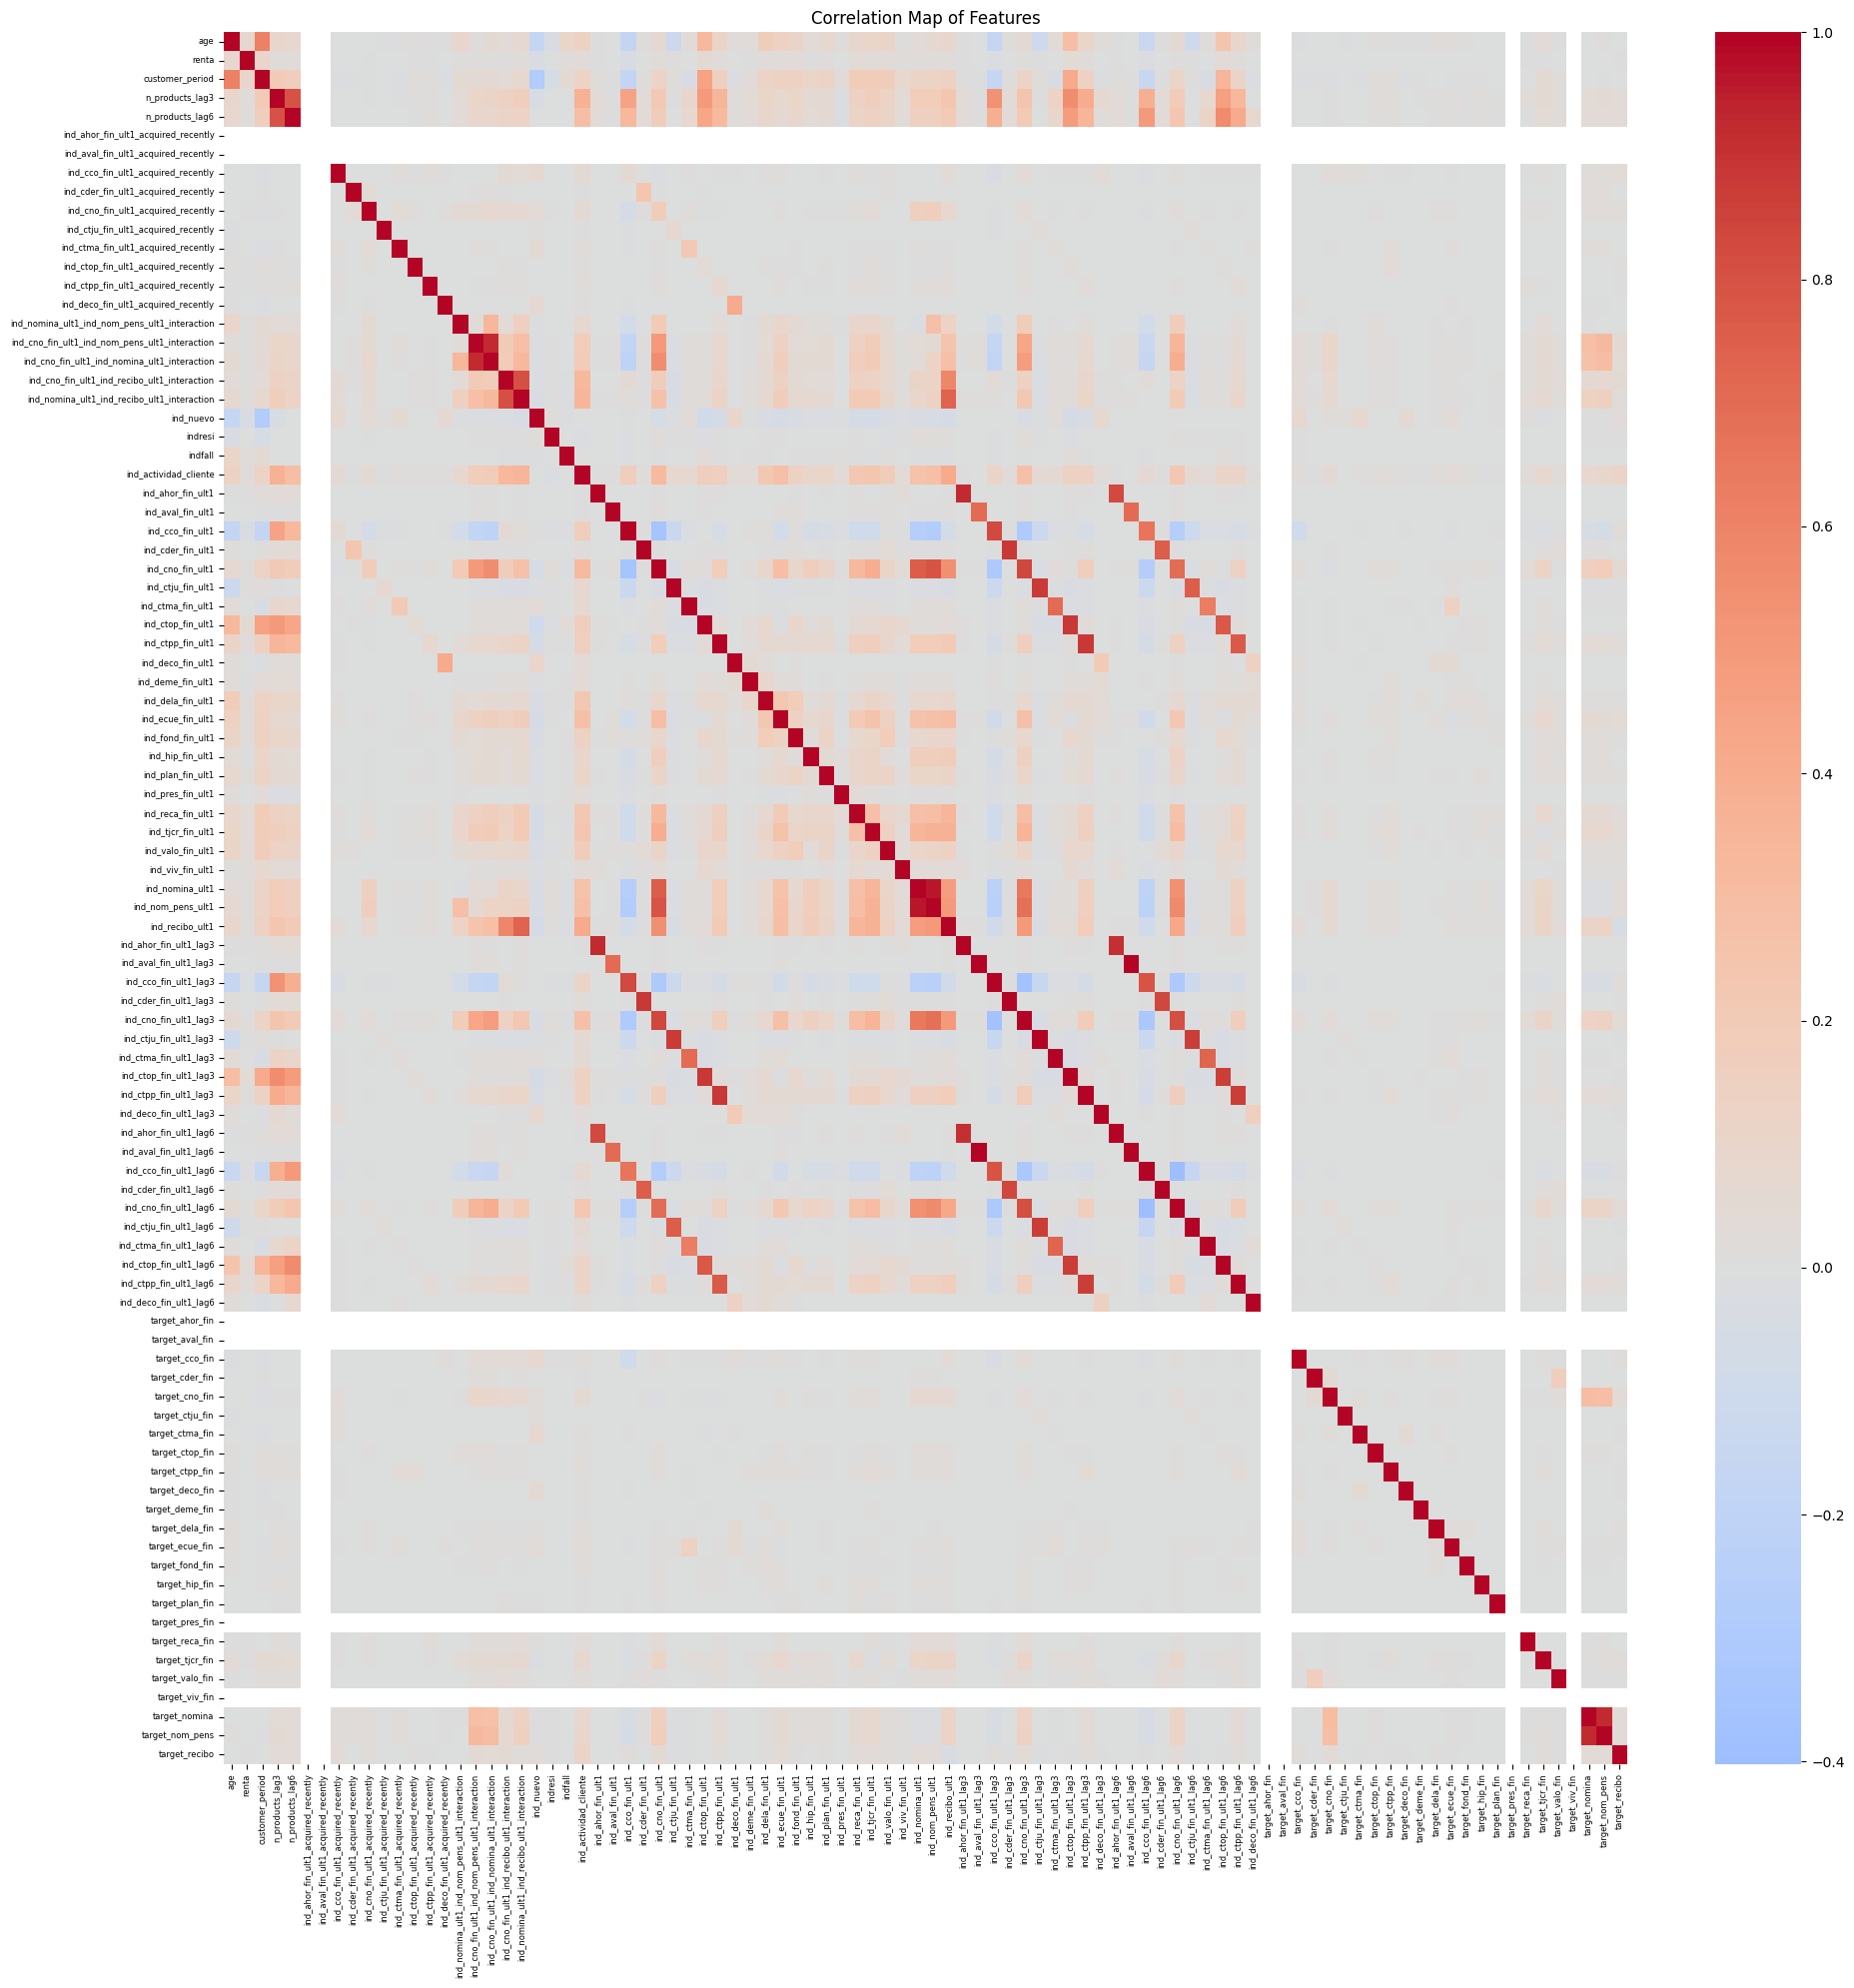

Top 10 strongest correlations:


feature_1,feature_2,correlation
str,str,f64
"""age""","""ind_ahor_fin_ult1_acquired_rec…",NaN
"""age""","""ind_aval_fin_ult1_acquired_rec…",NaN
"""age""","""target_ahor_fin""",NaN
"""age""","""target_aval_fin""",NaN
"""age""","""target_pres_fin""",NaN
"""age""","""target_viv_fin""",NaN
"""renta""","""ind_ahor_fin_ult1_acquired_rec…",NaN
"""renta""","""ind_aval_fin_ult1_acquired_rec…",NaN
"""renta""","""target_ahor_fin""",NaN


(shape: (92, 92)
 ┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ age      ┆ renta     ┆ customer_ ┆ n_product ┆ … ┆ target_vi ┆ target_no ┆ target_no ┆ target_re │
 │ ---      ┆ ---       ┆ period    ┆ s_lag3    ┆   ┆ v_fin     ┆ mina      ┆ m_pens    ┆ cibo      │
 │ f64      ┆ f64       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │          ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 1.0      ┆ 0.085381  ┆ 0.607962  ┆ 0.089768  ┆ … ┆ NaN       ┆ -0.0046   ┆ 0.011471  ┆ 0.002255  │
 │ 0.085381 ┆ 1.0       ┆ 0.099992  ┆ 0.020363  ┆ … ┆ NaN       ┆ -0.002049 ┆ -0.000441 ┆ 0.003971  │
 │ 0.607962 ┆ 0.099992  ┆ 1.0       ┆ 0.196314  ┆ … ┆ NaN       ┆ -0.00095  ┆ 0.007481  ┆ -0.004877 │
 │ 0.089768 ┆ 0.020363  ┆ 0.196314  ┆ 1.0       ┆ … ┆ NaN       ┆

In [20]:
# Clean up memory before correlation computation
gc.collect()

# Plot correlation heatmap (using 100k sample for memory efficiency)
plot_correlation_heatmap(
    df_preprocessed, 
    RESULTS_DIR
)

In [21]:
# Free up memory
del df_preprocessed
gc.collect()

0

#### Feature Engineering Step Summary

Added features:

- Targets;
Target features as 'target_nomina', 'target_nom_pens', etc.
That are 24 binary features (for each of 24 products that is 1 if the customer doesn't have the product now but will have it next month), thus identify product additions.
- Lag features;
Features as 'ind_deco_fin_ult1_lag3', 'ind_deco_fin_ult1_lag6', etc
That adds information about product holding history and customer lifecycle understanding.
- Aggregate lags;
Features as 'n_products_lag3', 'n_products_lag6'.
That adds information about  customer engagement trend.
- Recently acquired features;
Features as 'ind_aval_fin_ult1_acquired_recently', etc.
That capture actual change (customers who just started using a product), thus seems to be a highly predictive for recommendations (it's likely that a customer would add also hightly related products).
- Interaction features;
Features as 'ind_cno_fin_ult1_ind_nomina_ult1_interaction'.
That use 'one, but not the other' logic (1 if a customer has exactly one of two highly correlated products), thus identify cross-sell opportunities (in the case a customer has A but not B, so offer B).

Other features are:
- Customer profile;
Features as 'age', 'client_period', 'renta', 'canal_entrada', 'segmento', etc.
That add understanding of customers' demografics and custumer segments.
- Product columns.
Features as 'ind_nomina_ult1', 'ind_nom_pens_ult1, etc.
That indicate what products customers already have.

Data quality & signal assessment:

- Null targets were dropped for the last month, which is expected as no next month exists;
- No data leakage as features use current/past data, while targets are future-oriented;
- Highly imbalanced targets as product additions are rare events (most customers don't add products each month);
- Newly engineered features are internally consistent and correctly aligned in time (e.g., lags and targets computed by customer and date order), so no data leakage exist;
- Remaining missing values are largely structural or expected (e.g., no lag if there is no previous month, no recently acquired flag if product was never added), rather than data errors, and can either be left as-is for gradient boosting models;
- Some engineered features show high, but not perfect, correlation with existing variables (e.g., interactions and aggregate lags), that is logical and indicates genuine incremental information.

Thus, the engineered feature set now provides a rich, multi-angle view of each customer’s profile, behavior history, and product lifecycle, giving the model enough signal for recommendations.